In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import scale

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant 
import statsmodels.tools.eval_measures as sm_measure
import statsmodels.api as sm
import seaborn as sns                                                                             
    
from xgboost.sklearn import XGBRegressor
import xgboost as xgb

import math
%config InlineBackend.figure_format='retina'

In [2]:
#read into data
climate = pd.read_csv('Climate_regression.csv')
price = pd.read_csv('industrial_price.csv')
electricity = pd.read_csv('industrial-cleaned-Jul9.csv')
solar = pd.read_csv('industrial-distributed-solar-encoded.csv')
popu = pd.read_csv('Cleaned-Population_by-month-by-state_0714.csv')
energy_source = pd.read_csv('Electrcity_Source.csv')

In [3]:
#data merging

combine = price.merge(climate,how = 'inner',right_on = ['year','month','state'],left_on = ['Year','Month','State'])
combine = combine.merge(electricity,how = 'inner',on = ['Year','Month','State'])
combine = combine.merge(energy_source, how = 'inner', left_on = ['Year','Month','State'], right_on = ['YEAR','MONTH','STATE'])

combine = combine.merge(popu,how = 'inner',on = ['Year','Month','AK', 'AL', 'AR', 'AZ', 'CA', 'CO',
       'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
       'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])
combine = combine.merge(solar,how = 'left',on = ['year','month','AK', 'AL', 'AR', 'AZ', 'CA', 'CO',
       'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
       'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])
combine.columns
combine  =  combine.drop(['year', 'month', 'state','DC_x', 'US','DC_y','YEAR','MONTH','STATE',
                          'Megawatthours','mkwh','State','Year_Month'],axis = 1)


In [4]:
#dummy variable
combine['Season'] = combine.Month.map({12:'Winter',1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',7:'Summer',8:'Summer',9:'Fall',10:'Fall',11:'Fall'})
combine = pd.get_dummies(combine,columns = ['Season'])


In [5]:
#Drop Solar panel NaN data (Drop year 2001-2013)
combine = combine.dropna()

#Saved the cleaned file to csv
combine.to_csv('Industrial_regression.csv',index = False)

#Create a datafraem for regression analysis
regr = combine.drop(['Year', 'Month'],axis = 1)
#deal with Multicollinearity
regr = regr.drop(['PA','Season_Spring','Total'],axis = 1)

## Multicolinearity Test 

In [6]:
regr.columns

Index(['Cents/kWh', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'AK', 'AL', 'AR',
       'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN',
       'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC',
       'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'RI', 'SC',
       'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY',
       'industrial_usage', 'Population', 'solar-generation', 'Season_Fall',
       'Season_Summer', 'Season_Winter'],
      dtype='object')

In [7]:
#multicolinearity test
def cal_vif(df,columns):
    features= df[columns]
    X = add_constant(features)
    vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)    
    return vif

columns = ['Cents/kWh', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'Population', 'solar-generation']

print(cal_vif(regr,columns))

print()
print("-------------After removing TAVG--------------")
print()

regr.drop(['TAVG'],axis = 1,inplace=True)

columns = ['Cents/kWh', 'CLDD', 'AWND', 'HTDD','area', 'Population','solar-generation']
print(cal_vif(regr,columns))

const               6228.644523
Cents/kWh              1.129253
CLDD                  30.902087
TAVG                 471.704632
AWND                   1.119652
HTDD                 318.153807
area                   1.068077
Population             1.791753
solar-generation       1.781024
dtype: float64

-------------After removing TAVG--------------

const               19.440557
Cents/kWh            1.129237
CLDD                 1.787083
AWND                 1.118834
HTDD                 1.823300
area                 1.068077
Population           1.791727
solar-generation     1.781023
dtype: float64


## Train-Test Split 

In [8]:
#Train-Test Split
train, test = train_test_split(regr, test_size=0.2)

#splitX,y
def x_y_split(data):
    X = data.drop(['industrial_usage'],axis = 1)
    y = data.industrial_usage
    return X,y

X_train,y_train = x_y_split(train)
X_test,y_test = x_y_split(test)

## Scale the features 

In [9]:
#categorize X features
numeric_feature_name = ['Cents/kWh','CLDD', 'AWND', 'HTDD', 'area', 
                        'Population', 'solar-generation']

categorical_feature_name = ['Year', 'Month', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL',
       'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV',
       'NY', 'OH', 'OK', 'OR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA',
       'VT', 'WA', 'WI', 'WV', 'WY', 'Season_Summer', 'Season_Fall', 'Season_Winter']

In [10]:
# #Scale the data through Robust Scaler
# def robust_scaler(X_train, X_test):
#     robustScaler = RobustScaler() 
#     # fit and tranform the training data
#     X_train[numeric_feature_name] = robustScaler.fit_transform(X_train[numeric_feature_name]) 
#     # tranform test data
#     X_test[numeric_feature_name] = robustScaler.transform(X_test[numeric_feature_name]) 
#     return (X_train,X_test)

In [11]:
#Scale the data through MinMax Scaler
def minmax_scaler(X_train, X_test):
    robustScaler = MinMaxScaler() 
    # fit and tranform the training data
    X_train[numeric_feature_name] = robustScaler.fit_transform(X_train[numeric_feature_name]) 
    # tranform test data
    X_test[numeric_feature_name] = robustScaler.transform(X_test[numeric_feature_name]) 
    return (X_train,X_test)

In [12]:
X_train, X_test = minmax_scaler(X_train, X_test)

In [13]:
X_train.head()

,Cents/kWh,CLDD,AWND,HTDD,area,AK,AL,AR,AZ,CA,...,VT,WA,WI,WV,WY,Population,solar-generation,Season_Fall,Season_Summer,Season_Winter
8450,0.395472,0.000000,0.155434,0.706991,1.000000,1,0,0,0,0,...,0,0,0,0,0,0.004110,0.000000,0,0,1
9999,0.124514,0.069960,0.109961,0.080190,0.145102,0,0,0,0,0,...,0,0,0,0,1,0.000014,0.000000,0,1,0
10501,0.105766,0.740505,0.017582,0.000000,0.076683,0,1,0,0,0,...,0,0,0,0,0,0.110767,0.000000,0,1,0
8903,0.083127,0.005234,0.192772,0.291300,0.169487,0,0,0,1,0,...,0,0,0,0,0,0.162769,0.052402,1,0,0
11104,0.423417,0.404655,0.105229,0.015500,0.244405,0,0,0,0,1,...,0,0,0,0,0,0.999459,1.000000,0,1,0


In [14]:
def sm_regression(X_train,y_train,X_test,y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train)
    results = model.fit()
    results.params
    print(results.summary())
    predictions = results.predict(X_test)
    df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
    
    return df_pred

In [15]:
#Evaluate Performance: MAE, MSE, RMSE
def evaluate_performances(y_test, y_pred):
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_pred)))

In [16]:
#Visualize Output__Update version
def visualize_graph(df_pred):
    fig, axes = plt.subplots(3,1, figsize=(7,15))
    #Plot the result in box plot
    df_pred.plot(title="Actual vs. Predict result box plot",kind='box',ax=axes[0])
    #Plot the scatter plot 
    df_pred.plot.scatter(title="Actual vs. Predict result scatter plot",  x='Actual',y='Predicted', c='DarkBlue',ax=axes[1])
    #Plot the result in terms of kernel density estimation
    df_pred.plot(title="Actual vs. Predict result kernel density estimation", kind='density',ax=axes[2])

In [17]:
# Visualization
def visualization(y_pred, y_test):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))
    fig.suptitle('Predicted and Actual plot')
    ax1.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax1.set_title("Prediction Plot")
    ax1.legend(loc="upper right")
    ax2.plot(range(len(y_test)),y_test,'r',label="actual")
    ax2.set_title("Actual Plot")
    ax2.legend(loc="upper right")
    ax3.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax3.plot(range(len(y_test)),y_test,'r',label="test")
    ax3.legend(loc="upper right")
    ax3.set_title("Prediction vs Actual Plot")
    plt.show()

In [18]:
# Correlation Analysis between Y and X's
def correlation_analysis(data, x_vars_list, y_vars_list):
    g= sns.pairplot(data, x_vars = x_vars_list, y_vars = y_vars_list,  kind = 'reg')
#     g.fig.set_figheight(6)
#     g.fig.set_figwidth(10)
    plt.show()

In [19]:
def XGB(X_train,y_train):
    K = 5
    model = XGBRegressor(objective ='reg:squarederror')
    scores = cross_val_score(model, X_train, y_train, cv=K, scoring='neg_mean_squared_error', verbose=False)
    avg_rmse = math.sqrt(abs(np.mean(scores)))

    print('Average RMSE with {}-fold Cross Validation: {:.3f}'.format(K, avg_rmse))
   
    model.fit(X_train, y_train)

    fig, ax = plt.subplots(figsize=(20,40))
    xgb.plot_importance(model, height=0.8, ax=ax)

## Draw Variable Correlation 

In [20]:
X_train.columns

Index(['Cents/kWh', 'CLDD', 'AWND', 'HTDD', 'area', 'AK', 'AL', 'AR', 'AZ',
       'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS',
       'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND',
       'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'Population',
       'solar-generation', 'Season_Fall', 'Season_Summer', 'Season_Winter'],
      dtype='object')

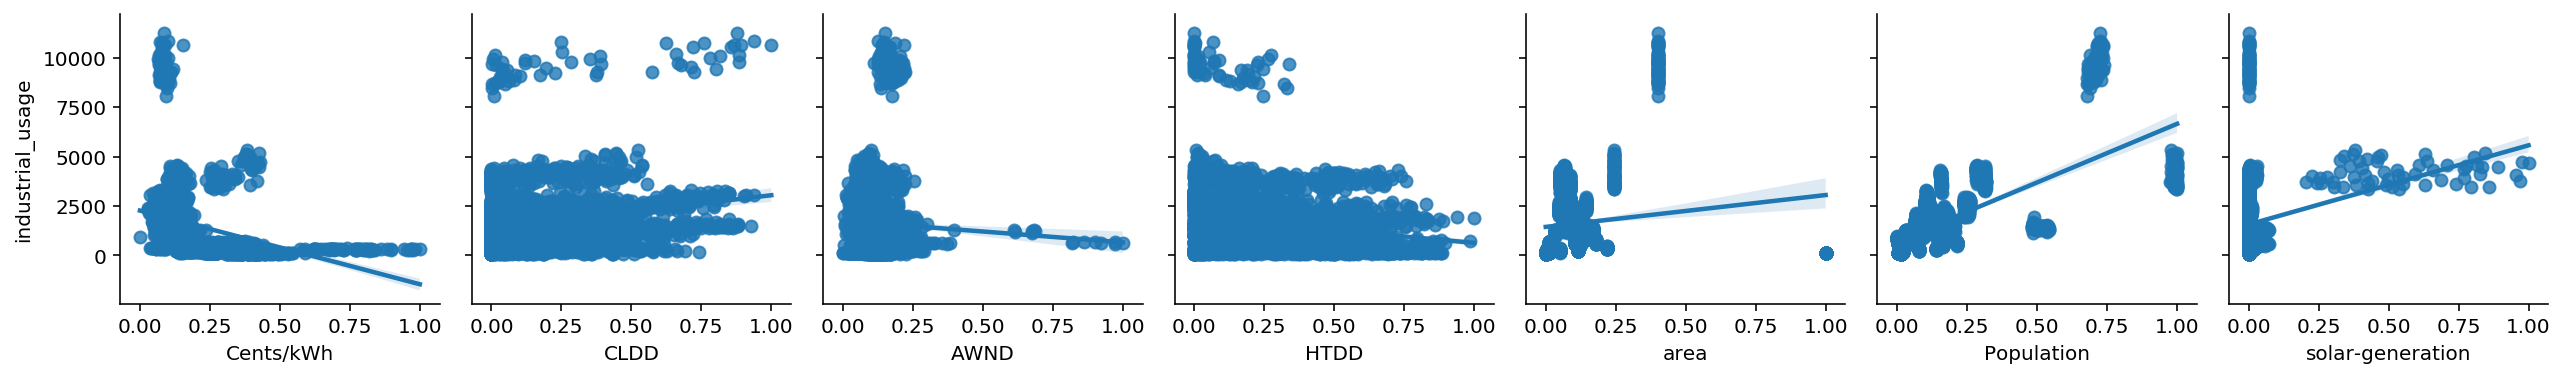

In [21]:
#concat for visualization
ind = pd.concat([X_train, y_train], axis=1)

# Correlation Analysis
x_vars_list = ['Cents/kWh', 'CLDD', 'AWND', 'HTDD', 'area', 'Population', 'solar-generation']
y_vars_list = 'industrial_usage'
correlation_analysis(ind,x_vars_list, y_vars_list)

## Linear Regression 

In [22]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
evaluate_performances(y_test, predictions)
df_pred_sklearn = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

Mean Absolute Error: 99.62302517361111
Mean Squared Error: 23517.437943183053
Root Mean Squared Error: 153.35396291972063


In [23]:
#Linear Regression coefficients
a  = lr.intercept_#Intercept
b = lr.coef_#Coefficient
print("Intercept",a,",Coefficient：",b)

Intercept -122345286076638.3 ,Coefficient： [ 4.99045366e+02  3.21424166e+02 -2.47631868e+01  4.17993178e+01
  1.82361545e+15 -1.70127016e+15 -1.74955683e+13 -1.95790940e+13
 -1.86733925e+14 -3.23356035e+14 -1.59532646e+14  1.11353176e+14
  1.19750500e+14 -5.41579234e+13 -3.67503140e+13  9.65595946e+13
 -2.80863656e+13 -1.03112530e+14 -3.26025037e+13  2.64921111e+13
 -9.95666883e+13  1.55137451e+13 -1.63081236e+13  9.75821164e+13
  9.24914970e+13  2.93315333e+13 -1.39244383e+14 -1.12367452e+14
 -6.49988537e+13 -6.53369456e+12 -2.77576193e+14 -2.13410200e+13
 -6.77365735e+13 -8.60182742e+13  1.00897066e+14  1.02615013e+14
 -2.07624156e+14 -1.77338819e+14 -2.33640740e+13  3.38091894e+12
 -6.55403505e+13 -1.43823742e+14  1.22345286e+14  3.85754605e+13
 -8.53778237e+13  1.07502227e+13 -6.11704441e+14 -1.06765572e+14
  9.01578383e+12  1.00160411e+14 -6.93858022e+13 -5.34377602e+13
  5.99906958e+13 -1.42265221e+14  4.75656250e+03  2.37187500e+01
  9.71875000e+00  3.08750000e+01 -4.90000000e+0

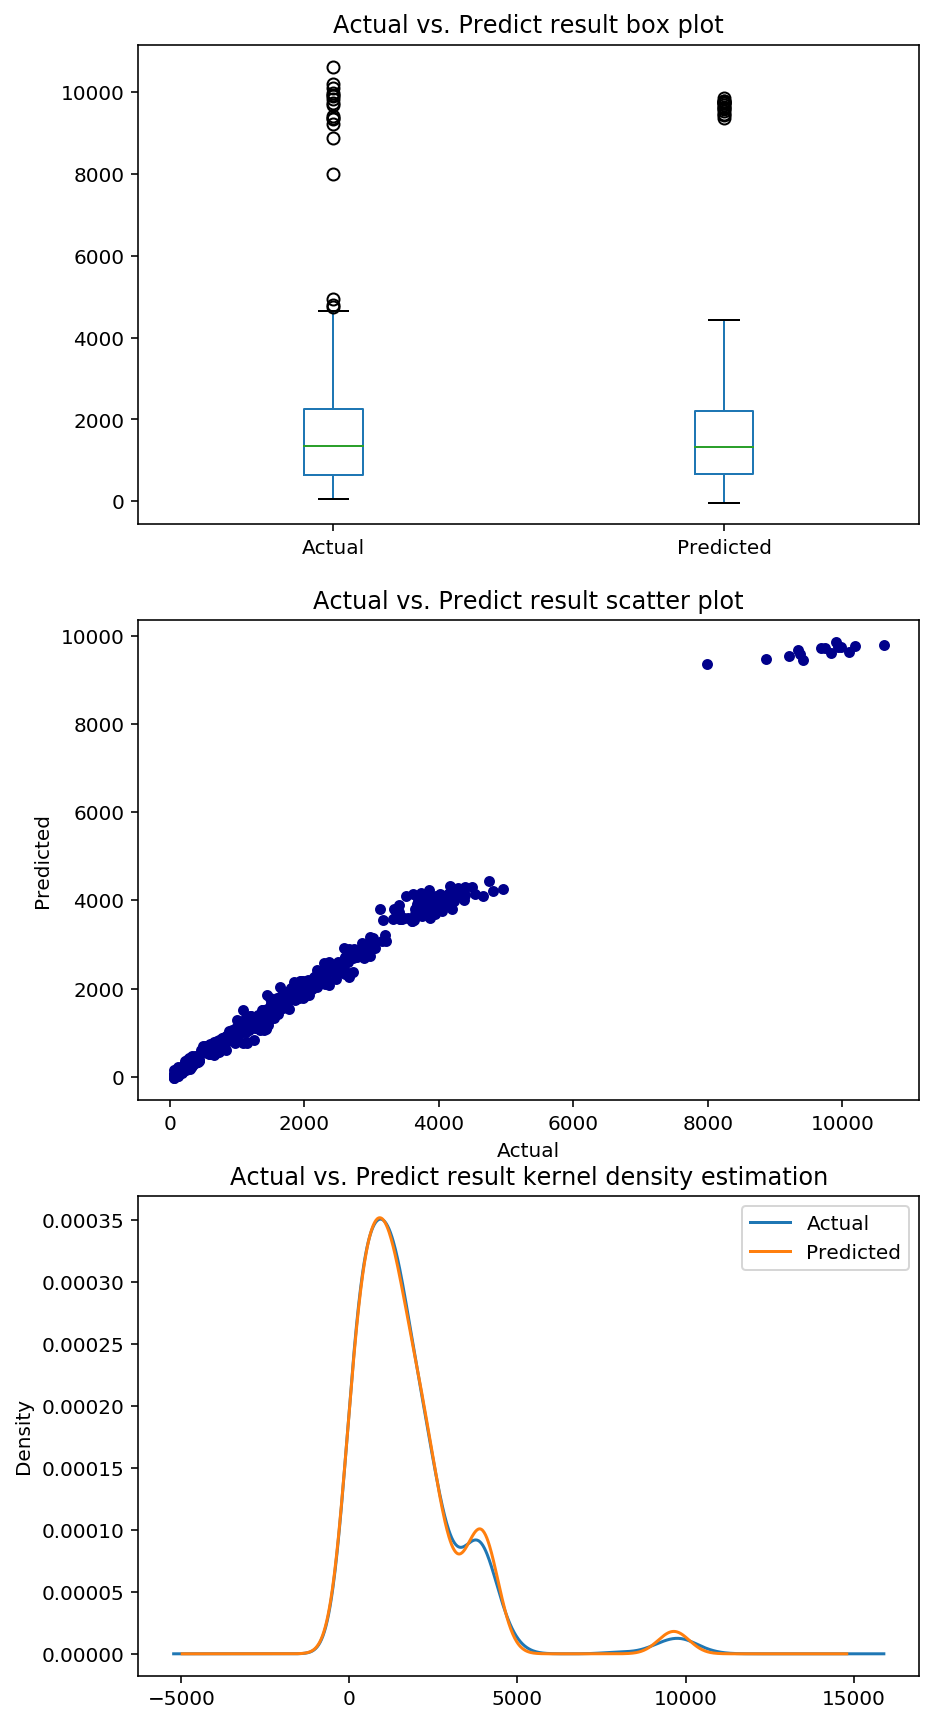

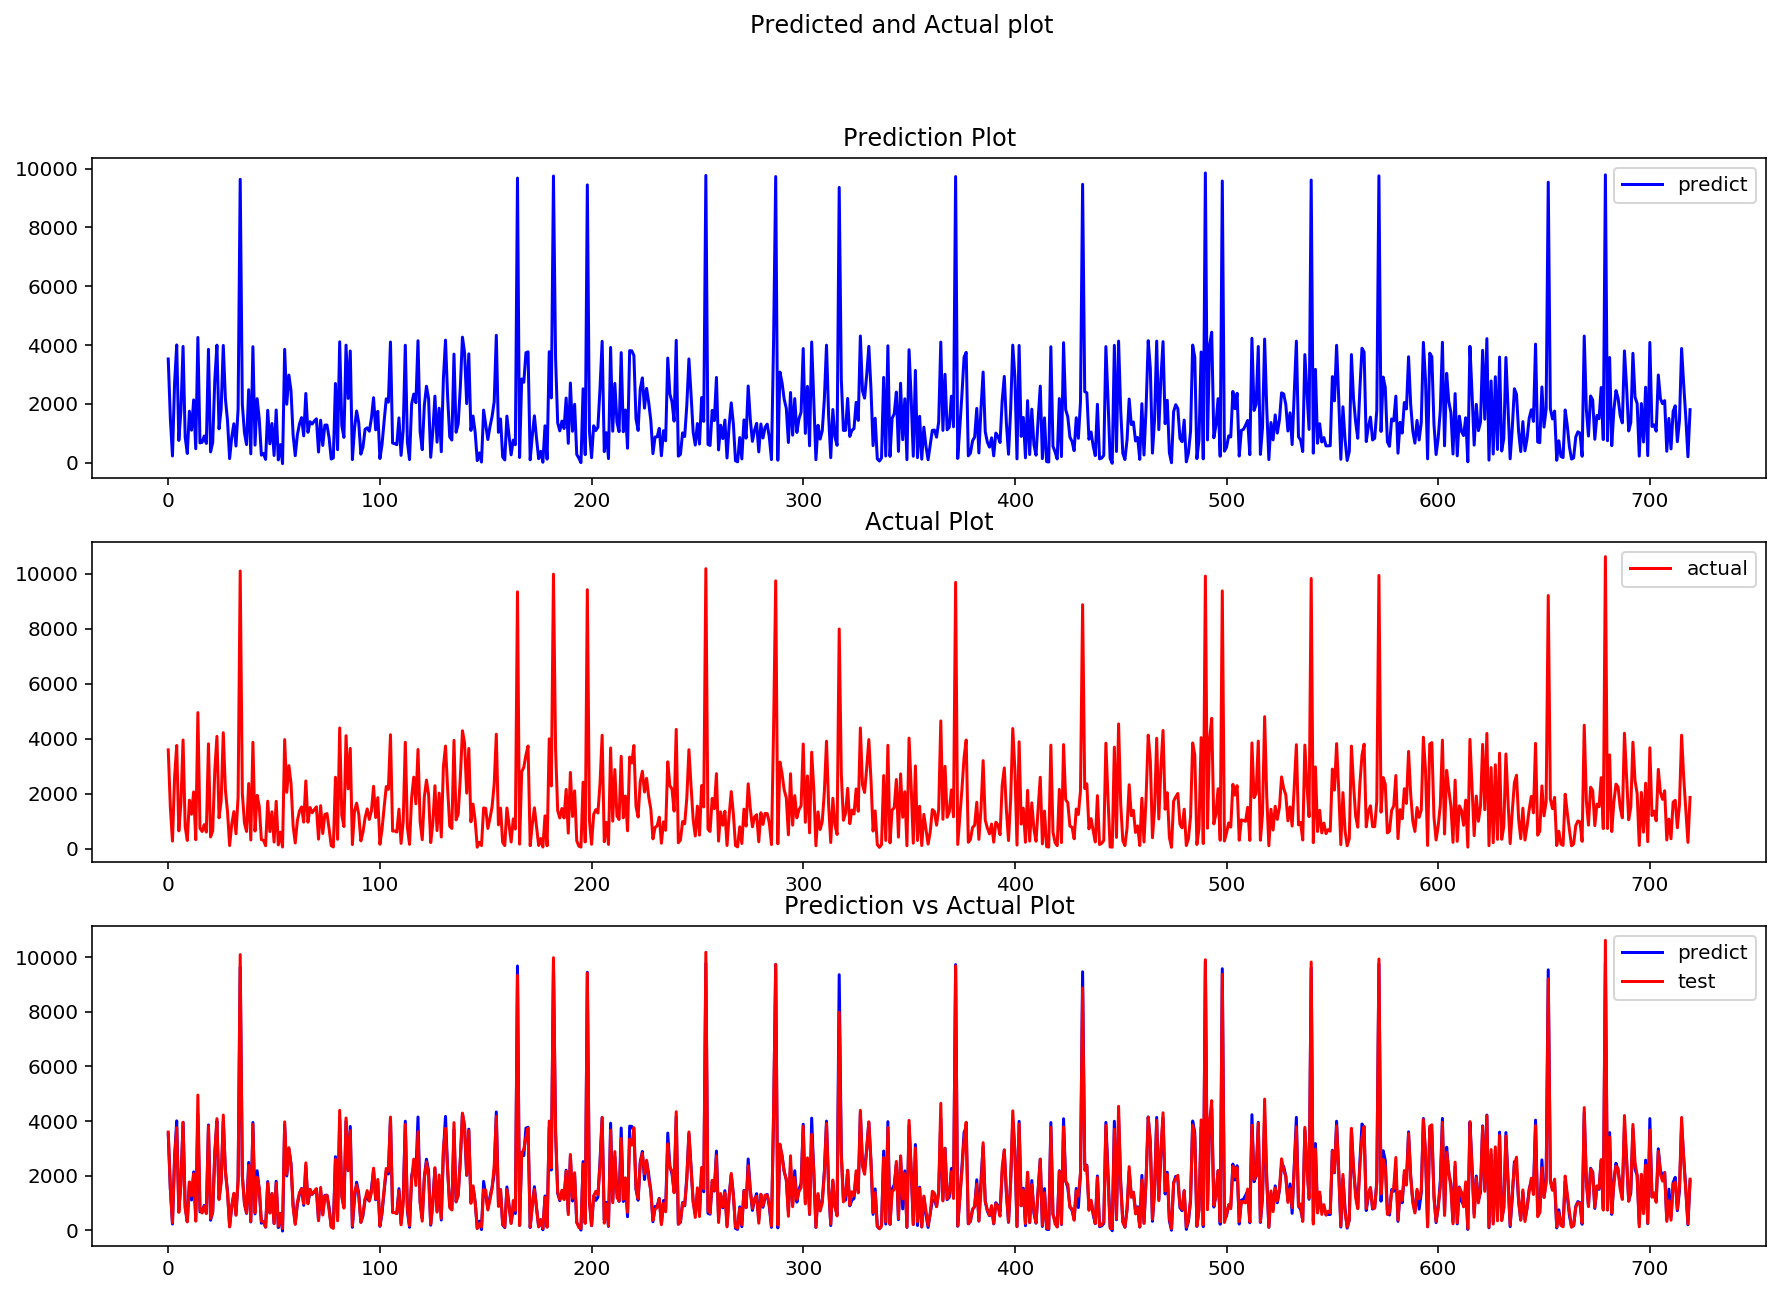

In [24]:
# Visualization
visualize_graph(df_pred_sklearn)
visualization(predictions,y_test)

                            OLS Regression Results                            
Dep. Variable:       industrial_usage   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     5500.
Date:                Tue, 21 Jul 2020   Prob (F-statistic):               0.00
Time:                        09:38:12   Log-Likelihood:                -18538.
No. Observations:                2880   AIC:                         3.719e+04
Df Residuals:                    2821   BIC:                         3.755e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2508.9125    238.348  

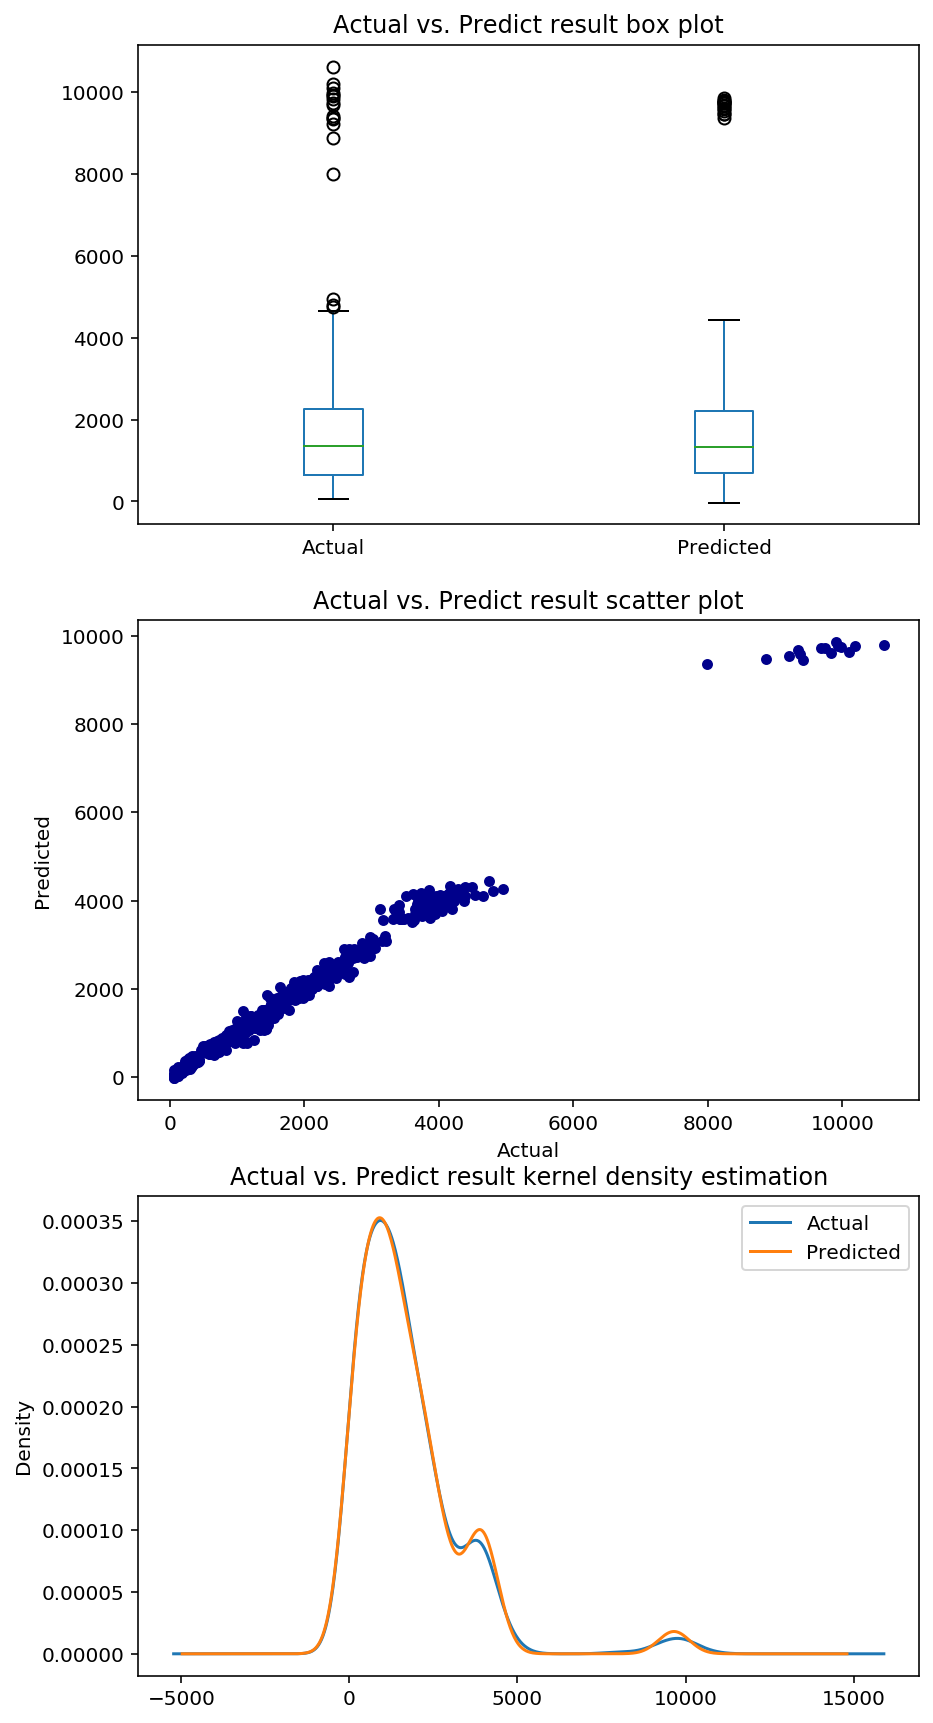

In [25]:
df_pred_sm = sm_regression(X_train,y_train,X_test,y_test)
visualize_graph(df_pred_sm)

## Feature Importances

Average RMSE with 5-fold Cross Validation: 105.931


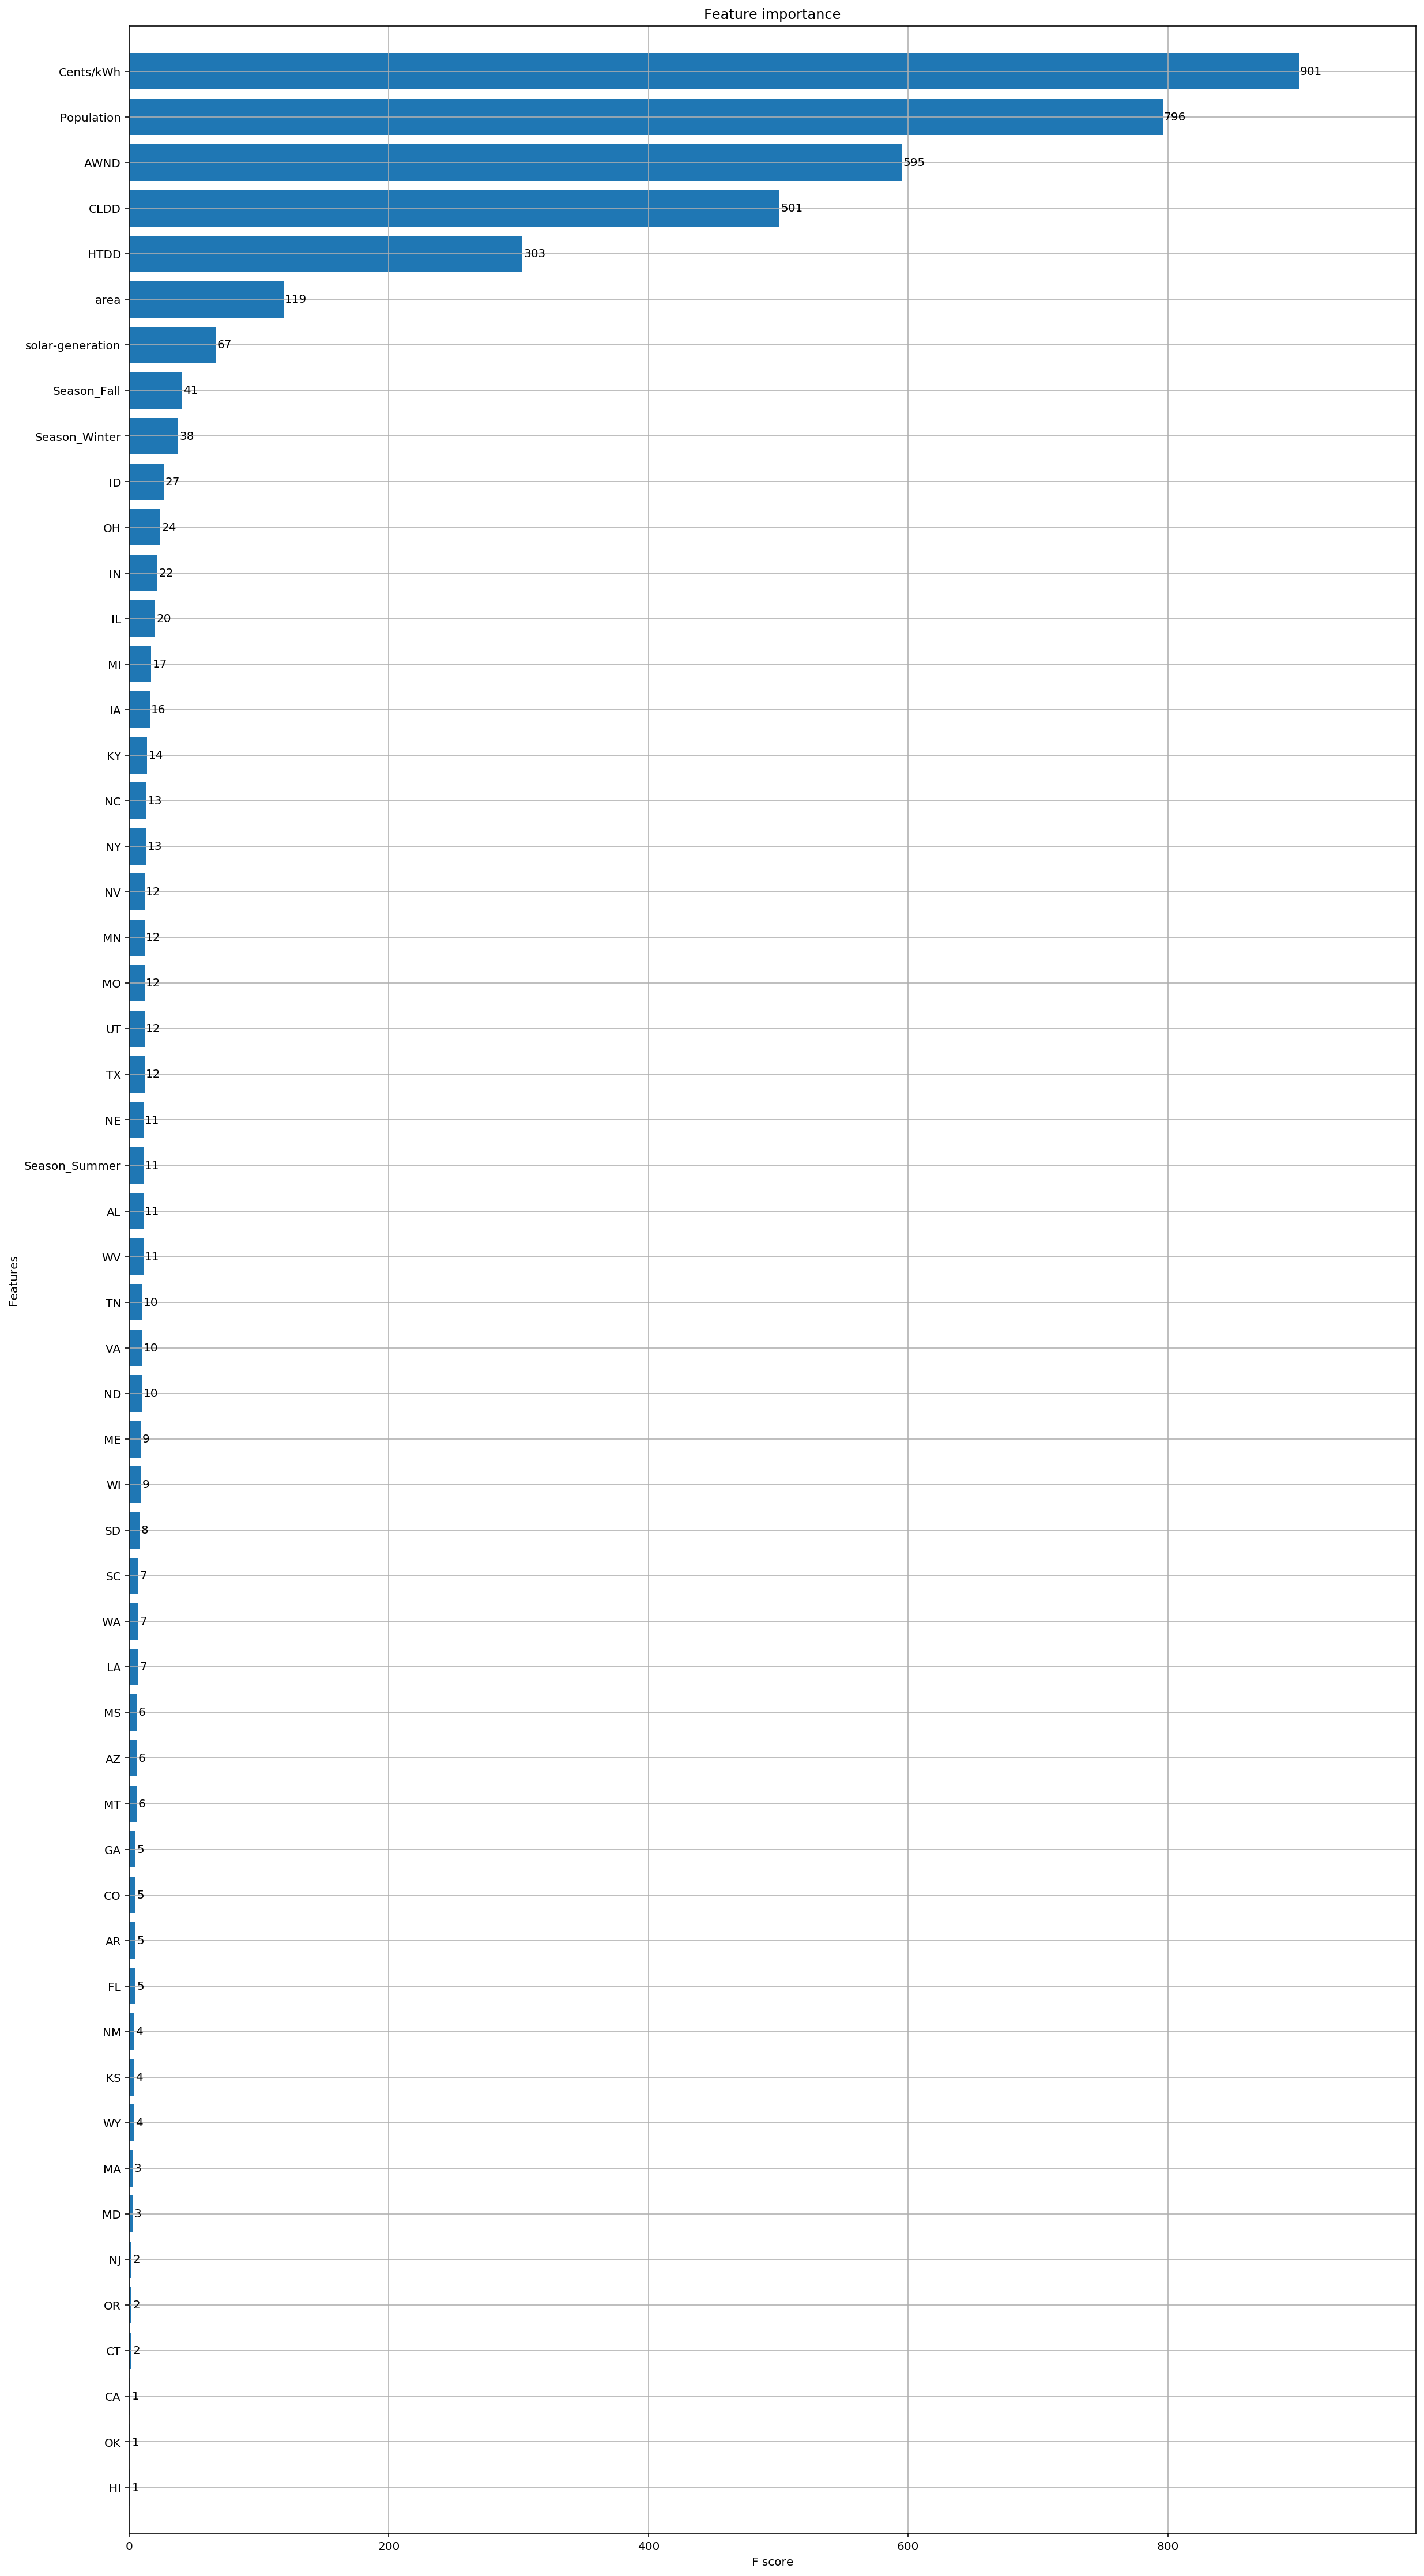

In [26]:
XGB(X_train, y_train)